In [56]:
import pandas as pd
import numpy as np

import xgboost as xgb 
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score
from sklearn.metrics import recall_score,f1_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.model_selection import learning_curve,ShuffleSplit

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import math
import copy 
import time
from datetime import datetime
import json
import os 
import logging 

logger=logging.getLogger("APP-ML")
logging.basicConfig(level=logging.INFO,format='%(asctime)s - %(name)s - %(levelname)s -%(message)s',datefmt='%Y-%m-%d %H:%M:')
logger.info("starting")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',10)


2024-12-15 21:18: - APP-ML - INFO -starting


In [57]:
from ml.load_data import load_data,load_adult_data,load_adult_train_test_data,show_df


In [58]:
################################################################
## Step-1:  load data
################################################################
one_data_mode=False
if one_data_mode:
    data_df=load_adult_data()
    show_df(data_df)
    data_df["label"]=data_df["income"].map(lambda x: 1 if x==">50K" else 0)
    print(data_df.columns)
    print(data_df["income"].value_counts())
    print(data_df["label"].value_counts())
else:
     train_df,test_df=load_adult_train_test_data()
     train_df["label"]=train_df["income"].map(lambda x: 1 if x==" >50K" else 0)
     test_df["label"]=test_df["income"].map(lambda x: 1 if x==" >50K." else 0)
     print(train_df["label"].value_counts())
     print(test_df["label"].value_counts())


2024-12-15 21:18: - ml.load_data - INFO -loading data from ../data/adult_train.csv
2024-12-15 21:18: - ml.load_data - INFO -loading data from ../data/adult_test.csv


label
0    24719
1     7841
Name: count, dtype: int64
label
0    12434
1     3846
Name: count, dtype: int64


In [59]:
train_df.head()
print(test_df["income"].value_counts())


income
<=50K.    12434
>50K.      3846
Name: count, dtype: int64


In [60]:
##################################################################
## Step-1.1: manually define continuous and categorical feature and label
## 人工梳理连续和离散变量
##################################################################

Continuous_Cols=['age','educational-num','capital-gain','capital-loss','hours-per-week']
Categorical_Cols=['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
Label_Cols=['label']
Drop_Cols=['fnlwgt','income'] # 因为fnlgwt属性记录的是人口普查员的ID，对预测结果无影响，故删除该列，income已经转换为label
Feature_Cols=Continuous_Cols+Categorical_Cols

print("continuous columns nums:",len(Continuous_Cols))
print("categorical columns nums:",len(Categorical_Cols))
print("target columns nums:",len(Label_Cols))
print("drop columns nums:",len(Drop_Cols))
print("feature columns nums:",len(Feature_Cols))

new_split_nums=len(Continuous_Cols)+len(Categorical_Cols)+len(Label_Cols)+len(Drop_Cols)
if one_data_mode:
    print("new_split_nums:",new_split_nums,"raw col nums:",data_df.shape[1])
else:
    print("new_split_nums:",new_split_nums,"raw col nums:",train_df.shape[1])


continuous columns nums: 5
categorical columns nums: 8
target columns nums: 1
drop columns nums: 2
feature columns nums: 13
new_split_nums: 16 raw col nums: 16


In [61]:
if one_data_mode:
    data_df=data_df.drop(columns=Drop_Cols)
    print(data_df.shape)
else:
    train_df=train_df.drop(columns=Drop_Cols)
    test_df=test_df.drop(columns=Drop_Cols)
    print(train_df.shape)
    print(test_df.shape) 


(32560, 14)
(16280, 14)


In [62]:
"income" in train_df.columns

False

In [63]:
########################
## 整体缺失值处理
########################
if one_data_mode:
    data_df[Continuous_Cols]=data_df[Continuous_Cols].fillna(0).astype(float)
    data_df[Categorical_Cols]=data_df[Categorical_Cols].fillna("UNKNOWN").astype(str)
else:
    train_df[Continuous_Cols]=train_df[Continuous_Cols].fillna(0).astype(float)
    train_df[Categorical_Cols]=train_df[Categorical_Cols].fillna("UNKNOWN").astype(str)
    
    test_df[Continuous_Cols]=test_df[Continuous_Cols].fillna(0).astype(float)
    test_df[Categorical_Cols]=test_df[Categorical_Cols].fillna("UNKNOWN").astype(str)


In [64]:
########################
## Global Setting     ##
########################
Random_Seed=666
Test_Size=0.2


In [65]:
##################################################################
## Step-1.2: 分割训练集和测试集
##################################################################
if one_data_mode:
    train_df,test_df=train_test_split(data_df,test_size=Test_Size,random_state=Random_Seed)
    print(train_df.shape)
    print(test_df.shape)


In [66]:
##################################################################
## Step-1.4: 对连续变量处理
##################################################################

def process_continuous_df(data_df,Continuous_Cols,processor_info=None,only_continuous=False):
    if only_continuous:
        data_df_cc=data_df[Continuous_Cols].copy()
    else:
        data_df_cc=data_df.copy()
    if not  processor_info:
        processor_info={}
    for sub_col in Continuous_Cols:
        sub_scaler=StandardScaler()
        if sub_col not in processor_info:
            data_df_cc[sub_col]=sub_scaler.fit_transform(data_df[[sub_col]])
            processor_info[sub_col]=sub_scaler
        else:
            sub_scaler=processor_info[sub_col]
            data_df_cc[sub_col]=sub_scaler.transform(data_df[[sub_col]])
    return data_df_cc,processor_info


In [67]:

train_df,continuous_processor_info=process_continuous_df(train_df,Continuous_Cols)


In [68]:
train_df.head(2)


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,label
0,0.837097,Self-emp-not-inc,Bachelors,1.134779,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.145914,-0.216663,-2.22212,United-States,0
1,-0.042640,Private,HS-grad,-0.420027,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.145914,-0.216663,-0.03543,United-States,0


In [69]:
test_df,_=process_continuous_df(test_df,Continuous_Cols,continuous_processor_info)


In [70]:
##################################################################
## Step-1.5: 对离散变量处理
##################################################################

def process_train_less_categories(dataframe,categorical_cols,top_n=5,other_category="OTHERS",categorical_info=None):
    """
    将[训练集]多类转换为top类，其余归为OTHERS。
    :param dataframe: 
    :param categorical_cols:离散特征字段list
    :param top_num: 
    :param other_category:
    :param categorical_info: 输入为空，但有输出值，给测试集使用
    :return: 共有top_num+1(others)类别。
    """
    df_cc=dataframe.copy()
    if not categorical_info:
        categorical_info={}
        # 定义一个函数用于转换数据
    def replace_rare_categories(x,top_categories):
        return x if x in top_categories else other_category
    
    for sub_col in categorical_cols:
        # 获取训练集中该列的前n个最常见类别
        sub_top_categories = dataframe[sub_col].value_counts().nlargest(top_n).index
        # 将训练集和测试集中不属于前n个类别的值替换为 'OTHERS'
        if sub_col not in categorical_info:
            categorical_info[sub_col]=list(sub_top_categories)
        df_cc[sub_col] = df_cc[sub_col].apply(lambda x:replace_rare_categories(x,sub_top_categories))
    return df_cc,categorical_info

def process_test_less_categories(dataframe,categorical_cols,top_n=5,other_category="OTHERS",categorical_info=None):
    """
    将[训练集]多类转换为top类，其余归为OTHERS。
    :param dataframe: 
    :param categorical_cols:离散特征字段list
    :param top_num: 
    :param other_category:
    :param categorical_info: 输入为，训练集处理后的信息
    :return: 共有top_num+1(others)类别。
    """
    df_cc=dataframe.copy()
    if not categorical_info:
        raise ValueError("category_info非空，请首先使用process_train_less_categories处理")
        # 定义一个函数用于转换数据
    def replace_rare_categories(x,top_categories):
        return x if x in top_categories else other_category
    
    for sub_col in categorical_cols:
        # 获取训练集中该列的前n个最常见类别
        sub_top_categories=categorical_info[sub_col]
        df_cc[sub_col] = df_cc[sub_col].apply(lambda x:replace_rare_categories(x,sub_top_categories))
    return df_cc,categorical_info


def process_train_categorical_dummies_df(data_df,Categorical_Cols,only_dummy=False):
    """
    处理训练集的哑变量，然后传递相关信息给验证集，测试集使用。
    :param data_df: 
    :param Categorical_Cols: 
    :param only_dummy: 是否只处理哑变量。如果是，直返回离散哑变量的数据；如果为否，则返回连续+离散哑变量全部特征。
    :return: 删除Categorical_Cols原始列数据，增加Categorical_Cols的哑变量为新列。
    """
    if only_dummy:
        data_df_cc=data_df[Categorical_Cols].copy()
    else:
        data_df_cc=data_df.copy()
    #categorical_col_names=data_df_cc.columns.tolist()
    #if Categorical_Cols and len(Categorical_Cols)==len(categorical_col_names):
    #    categorical_col_names=Categorical_Cols
    data_df_cc=data_df_cc.drop(Categorical_Cols,axis=1)
    for sub_col in Categorical_Cols:
        sub_col_dummy_df=pd.get_dummies(data_df[sub_col],prefix=sub_col,dummy_na=True).astype(int)
        data_df_cc=pd.concat([data_df_cc,sub_col_dummy_df],axis=1,ignore_index=False)
    return data_df_cc


def process_test_categorical_dummies_df(data_df,Categorical_Cols,train_dummies_cols,only_dummy=False):
    """
    基于process_train_categorical_dummies_df的相关信息继续处理验证集，测试集使用。保持特征的一致性
    :param data_df: test_ata_df
    :param Categorical_Cols: 
    :param train_dummies_cols: 训练集哑变量处理后的特征
    :param only_dummy: 是否只处理哑变量。如果为否，则处理全部特征。
    :return: 保持和训练集哑变量相同列的数据。
    """
    if only_dummy:
        test_raw_df_cc=data_df[Categorical_Cols].copy()
    else:
        test_raw_df_cc=data_df.copy()
    test_encoded_df=process_train_categorical_dummies_df(test_raw_df_cc,Categorical_Cols)
    test_encoded_df=test_encoded_df.reindex(columns=train_dummies_cols,fill_value=0) #对齐测试集的列数据，保持和训练集一致。
    return test_encoded_df



In [71]:
###################
## 可选：压缩离散特征数量
###################
top_less_n=5
train_cate_less_df,train_less_category_info=process_train_less_categories(train_df,Categorical_Cols,top_n=top_less_n,other_category="OTHERS")
test_cate_less_df,_=process_train_less_categories(test_df,Categorical_Cols,categorical_info=train_less_category_info)



In [72]:
print(train_cate_less_df.shape)
print(test_cate_less_df.shape)


(32560, 14)
(16280, 14)


In [73]:
###################
## 离散变量哑变量处理
###################
train_dummies_df=process_train_categorical_dummies_df(train_cate_less_df,Categorical_Cols)
train_dummies_columns=train_dummies_df.columns
test_dummies_df=process_test_categorical_dummies_df(test_cate_less_df,Categorical_Cols,train_dummies_columns)


In [74]:

train_dummies_df.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,label,workclass_ ?,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_OTHERS,workclass_nan,education_ Assoc-voc,education_ Bachelors,education_ HS-grad,education_ Masters,education_ Some-college,education_OTHERS,education_nan,marital-status_ Divorced,marital-status_ Married-civ-spouse,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,marital-status_OTHERS,marital-status_nan,occupation_ Adm-clerical,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Prof-specialty,occupation_ Sales,occupation_OTHERS,occupation_nan,relationship_ Husband,relationship_ Not-in-family,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,relationship_OTHERS,relationship_nan,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,race_nan,gender_ Female,gender_ Male,gender_nan,native-country_ ?,native-country_ Germany,native-country_ Mexico,native-country_ Philippines,native-country_ United-States,native-country_OTHERS,native-country_nan
0,0.837097,1.134779,-0.145914,-0.216663,-2.22212,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,-0.042640,-0.420027,-0.145914,-0.216663,-0.03543,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,1.057031,-1.197429,-0.145914,-0.216663,-0.03543,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,-0.775755,1.134779,-0.145914,-0.216663,-0.03543,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,-0.115952,1.523480,-0.145914,-0.216663,-0.03543,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [75]:
print(train_dummies_df.shape)
print(test_dummies_df.shape)


(32560, 57)
(16280, 57)


In [76]:

##################################################################
## Step-1.6: 样本抽样
##################################################################

def build_ratio_df(Train_DF,neg_pos_ratio=5,label_col="ifclaim_succ"):
    Random_seed=666
    print(f"label col: {label_col}")
    train_pos_df=Train_DF.loc[Train_DF[label_col]!=0,:].copy()
    print(f"train pos df shape: f{train_pos_df.shape}")
    # 负样本抽样是正样本的倍数
    neg_sample_nums=train_pos_df.shape[0]*neg_pos_ratio
    print(f"neg_pos_ratio: {neg_pos_ratio}, neg_sample_nums: {neg_sample_nums}")
    train_neg_df=Train_DF.loc[Train_DF[label_col]==0,:].sample(n=neg_sample_nums).copy()
    print(f"train_neg_df shape: {train_neg_df.shape}" )
    Train_sele_DF=pd.concat([train_pos_df,train_neg_df],ignore_index=True)
    print(Train_sele_DF[label_col].value_counts())
    Train_sele_DF=Train_sele_DF.sample(frac=1.0,random_state=Random_seed)
    ## 打乱正负样本
    Train_sele_DF=Train_sele_DF.reset_index(drop=True)
    print(f"Train_sele_DF shape: {Train_sele_DF.shape}")
    return Train_sele_DF

def build_neg_downsample_df(Train_DF,neg_down_rate=0.5,label_col="ifclaim_succ"):
    """
    将正样本往负样本的预设样例数或比例向上述样。常规负样本较多。
    """
    
    Random_seed=666
    
    print(f"label_col: {label_col}")
    ## 保存正样本的原始数据都能出险
    train_pos_df_keep=Train_DF.loc[Train_DF[label_col]!=0,:].copy()
    print(f"train_pos_df_keep shape: {train_pos_df_keep.shape}")
    
    ##先负样本按比例neg_rate向下抽样
    train_neg_df_raw=Train_DF.loc[Train_DF[label_col]==0,:].copy()
    neg_downsample_nums=int(train_neg_df_raw.shape[0]*neg_down_rate)
    print(f"neg_down_rate: {neg_down_rate}, neg_downsample_nums :{neg_downsample_nums}")
    train_neg_df_sample=train_neg_df_raw.sample(n=neg_downsample_nums,random_state=Random_seed)
    
    ##再正样本oversample向上抽样，保持和负样本一致
    pos_oversample_nums=max(neg_downsample_nums-train_pos_df_keep.shape[0],0)
    train_pos_df_oversample=Train_DF.loc[Train_DF[label_col]==1,:].sample(n=pos_oversample_nums,replace=True).copy()
    print(f"train_pos_df_oversample shape: {train_pos_df_oversample.shape}")
    
    Train_sele_DF=pd.concat([train_neg_df_sample,train_pos_df_keep,train_pos_df_oversample], ignore_index=True)
    print(Train_sele_DF[label_col].value_counts())
    Train_sele_DF=Train_sele_DF.sample(frac=1.0, random_state=Random_seed)   ## 打乱正负样本
    Train_sele_DF=Train_sele_DF.reset_index(drop=True)
    print(f"Train_sele_DF shape: {Train_sele_DF.shape}")
    return Train_sele_DF

def build_sample_data(dataframe, label_col, neg_pos_ratio=3, neg_down_rate=0.5, sample_mode="oversample"):

    """
    只返回整体的dataframe.
    label_col:str
    neg_pos_ratio: 负样本是正样本的倍数。
    neg_down_rate: 负样本向下抽样，为负样本本身的百分之几（默认50%），然后将正样本向上抽样，最终样本数一致。
    sample_mode: 抽样模式['ratio', 'downsample', 'oversample', 'norm'],一般负样本量大于正样本量。
                 ratio和neg_pos_ratio一起使用；
                 downsample和neg_down_rate一起使用；
                 oversample表示正样本向上抽样，最终和负样本一致。降采样没用到。
                 norm表示保持原样。
    """

    print(f"sample_mode: {sample_mode}")

    if sample_mode == "ratio":
        sample_df = build_ratio_df(dataframe, neg_pos_ratio, label_col)
        print(f"neg_pos_ratio: {neg_pos_ratio}, sample_df shape: {sample_df.shape}")

    elif sample_mode == "downsample":
        sample_df = build_neg_downsample_df(dataframe, neg_down_rate, label_col)
        print(f"neg_pos_ratio: {neg_pos_ratio}, train_sample_df shape: {sample_df.shape}")

    elif sample_mode == "oversample":
        ros = RandomOverSampler(random_state=666)
        sample_df, _ = ros.fit_resample(dataframe, dataframe[label_col])

    else:
        return dataframe

    return sample_df

def build_sample_feature_data(dataframe, feature_cols, label_col, neg_pos_ratio=3, neg_down_rate=0.5, sample_mode="oversample"):

    """
    返回2个结果，feature_df,label.
    feature_cols: List[str]
    label_col:str
    neg_pos_ratio: 负样本是正样本的倍数。
    neg_down_rate: 负样本向下抽样，为负样本本身的百分之几（默认50%），然后将正样本向上抽样，最终样本数一致。
    sample_mode: 抽样模式['ratio', 'downsample', 'oversample', 'norm'],一般负样本量大于正样本量。
                 ratio和neg_pos_ratio一起使用；
                 downsample和neg_down_rate一起使用；
                 oversample表示正样本向上抽样，最终和负样本一致。降采样没用到。
                 norm表示保持原样。
    """

    print(f"sample_mode: {sample_mode}")

    if sample_mode == "ratio":
        sample_df = build_ratio_df(dataframe, neg_pos_ratio, label_col)
        print(f"neg_pos_ratio: {neg_pos_ratio}, sample_df shape: {sample_df.shape}")
        train_feat_df = sample_df[feature_cols].copy()
        train_label = sample_df[label_col].copy()

    elif sample_mode == "downsample":
        sample_df = build_neg_downsample_df(dataframe, neg_down_rate, label_col)
        print(f"neg_pos_ratio: {neg_pos_ratio}, train_sample_df shape: {sample_df.shape}")
        train_feat_df = sample_df[feature_cols].copy()
        train_label = sample_df[label_col].copy()

    elif sample_mode == "oversample":
        ros = RandomOverSampler(random_state=666)
        feat_df_pre = dataframe[feature_cols].copy()
        label_pre = dataframe[label_col].copy()
        train_feat_df, train_label = ros.fit_resample(feat_df_pre, label_pre)

    else:
        train_feat_df = dataframe[feature_cols].copy()
        train_label = dataframe[label_col].copy()

    return train_feat_df, train_label



In [77]:

neg_pos_ratio=3
neg_down_rate=0.5

#sample_mode="ratio"
#sample_mode="downsample"
#sample_mode="oversample"
sample_mode="norm"

label_col="label"

train_dummies_df = build_sample_data(train_dummies_df, label_col, sample_mode=sample_mode)

print("****"*5)
print(train_dummies_df[label_col].value_counts())
print("****"*5)
print(test_dummies_df[label_col].value_counts())



sample_mode: norm
********************
label
0    24719
1     7841
Name: count, dtype: int64
********************
label
0    12434
1     3846
Name: count, dtype: int64


In [78]:
train_feat_df=train_dummies_df.drop(columns=[label_col])
train_label =train_dummies_df[label_col]

test_feat_df=test_dummies_df.drop(columns=[label_col])
test_label =test_dummies_df[label_col]


In [94]:
##################################################################
## Step-2: Train
##################################################################
##################################################################
## Step-2-1: XGB-Native-api
##################################################################
## 转换为DMatrix格式
dtrain=xgb.DMatrix(data=train_feat_df,label=train_label) # 不使用train_feat_df.values,可以显示特征重要性的字段名。
dtest=xgb.DMatrix(data=test_feat_df)


In [95]:
#设置参数
xgb_params={"objective":"binary:logistic",
            "max_depth":5}



In [96]:
# 训练模型
num_train_round=100 # 迭代次数
xgb_model_native=xgb.train(xgb_params, dtrain, num_train_round)


In [97]:
def plot_feature_importance(model, importance_type='weight', n_top=20):
    """
    展示XGBoost模型的特征重要性
    
    参数:
    model: 训练好的XGBoost模型
    X: 特征数据DataFrame
    importance_type: 特征重要性类型，可选 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
    n_top: 展示前n个最重要的特征
    """
    # 获取特征重要性
    importance_dict = model.get_score(importance_type=importance_type)
    
    # 转换为DataFrame
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    })
    
    # 排序并选择前n个特征
    importance_df = importance_df.sort_values('importance', ascending=False).head(n_top)
    
    # 计算相对重要性（百分比）
    total_importance = importance_df['importance'].sum()
    importance_df['importance_percent'] = importance_df['importance'] / total_importance * 100
    
    # 绘图设置
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')
    
    # 添加标题和标签
    plt.title(f'Top {n_top} Feature Importance ({importance_type})')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    
    # 在条形图上添加百分比标签
    for i, v in enumerate(importance_df['importance_percent']):
        plt.text(importance_df['importance'].iloc[i], i, f' {v:.1f}%')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

def get_all_importance_types(model):
    """
    获取所有类型的特征重要性
    """
    importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    all_importance = {}
    for imp_type in importance_types:
        try:
            importance = model.get_score(importance_type=imp_type)
            all_importance[imp_type] = pd.Series(importance)
        except:
            print(f"无法获取 {imp_type} 类型的特征重要性")
    # 合并所有类型的特征重要性
    importance_df = pd.DataFrame(all_importance)
    importance_df = importance_df.fillna(0)
    return importance_df




特征重要性类型: weight


C:\Users\86183\AppData\Local\Temp\ipykernel_7900\2214779265.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')


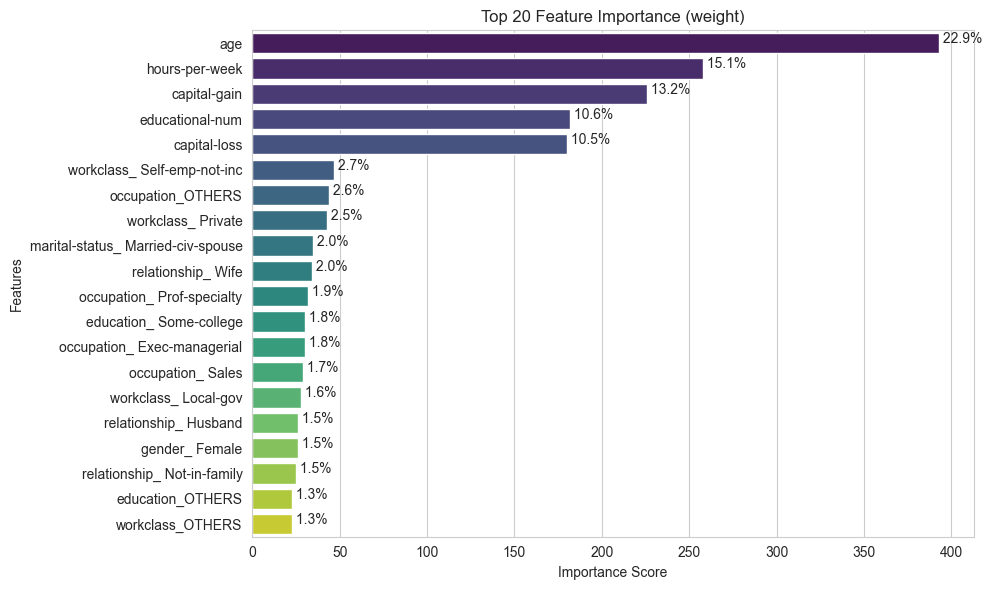


具体数值：
                        feature  importance  importance_percent
0                           age       393.0           22.928821
4                hours-per-week       258.0           15.052509
2                  capital-gain       226.0           13.185531
1               educational-num       182.0           10.618436
3                  capital-loss       180.0           10.501750
..                          ...         ...                 ...
29        relationship_ Husband        26.0            1.516919
40               gender_ Female        26.0            1.516919
30  relationship_ Not-in-family        25.0            1.458576
16             education_OTHERS        23.0            1.341890
10             workclass_OTHERS        23.0            1.341890

[20 rows x 3 columns]

特征重要性类型: gain


C:\Users\86183\AppData\Local\Temp\ipykernel_7900\2214779265.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')


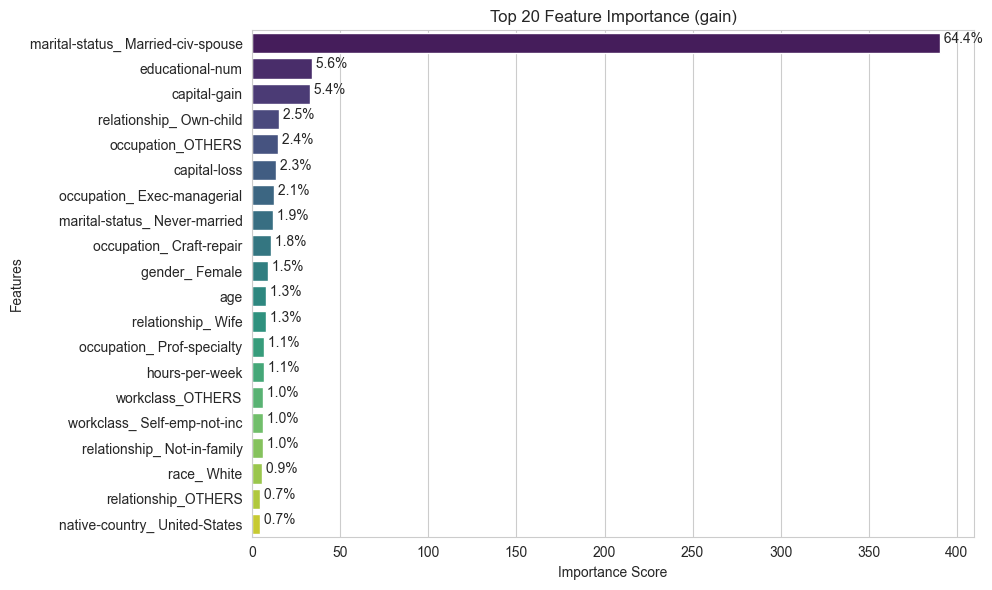


具体数值：
                               feature  importance  importance_percent
18  marital-status_ Married-civ-spouse  390.188843           64.390083
1                      educational-num   33.828014            5.582396
2                         capital-gain   32.722939            5.400033
31             relationship_ Own-child   15.194112            2.507376
28                   occupation_OTHERS   14.405518            2.377240
..                                 ...         ...                 ...
8          workclass_ Self-emp-not-inc    6.238741            1.029535
30         relationship_ Not-in-family    6.180159            1.019868
39                         race_ White    5.388634            0.889248
34                 relationship_OTHERS    4.470800            0.737784
45       native-country_ United-States    4.115233            0.679108

[20 rows x 3 columns]

特征重要性类型: cover


C:\Users\86183\AppData\Local\Temp\ipykernel_7900\2214779265.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')


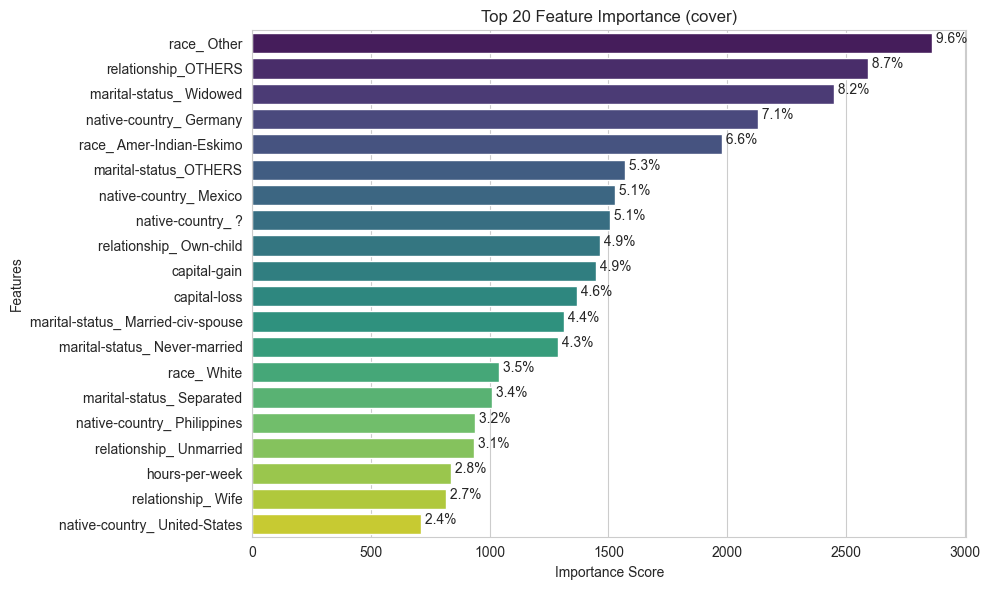


具体数值：
                          feature   importance  importance_percent
38                    race_ Other  2863.547852            9.615700
34            relationship_OTHERS  2593.497559            8.708880
21        marital-status_ Widowed  2450.824707            8.229789
42        native-country_ Germany  2127.885010            7.145368
35       race_ Amer-Indian-Eskimo  1978.568604            6.643969
..                            ...          ...                 ...
44    native-country_ Philippines   939.182861            3.153745
32        relationship_ Unmarried   933.276184            3.133911
4                  hours-per-week   838.022400            2.814052
33             relationship_ Wife   814.217468            2.734116
45  native-country_ United-States   708.742371            2.379934

[20 rows x 3 columns]


In [98]:
# 绘制不同类型的特征重要性
importance_types = ['weight', 'gain', 'cover']
for imp_type in importance_types:
    print(f"\n特征重要性类型: {imp_type}")
    imp_df = plot_feature_importance(xgb_model_native, importance_type=imp_type)
    print("\n具体数值：")
    print(imp_df)



In [99]:
# 获取所有类型的特征重要性
print("\n所有类型的特征重要性：")
all_importance = get_all_importance_types(xgb_model_native)
print(all_importance)



所有类型的特征重要性：
                               weight       gain        cover   total_gain  \
age                             393.0   8.070065   595.740845  3171.535889   
educational-num                 182.0  33.828014   576.296021  6156.698730   
capital-gain                    226.0  32.722939  1448.380249  7395.383789   
capital-loss                    180.0  13.692337  1367.318970  2464.620605   
hours-per-week                  258.0   6.613506   838.022400  1706.284546   
...                               ...        ...          ...          ...   
native-country_ Germany           3.0   1.576772  2127.885010     4.730316   
native-country_ Mexico            8.0   4.052328  1527.085205    32.418625   
native-country_ Philippines       9.0   3.828238   939.182861    34.454147   
native-country_ United-States    12.0   4.115233   708.742371    49.382797   
native-country_OTHERS             7.0   3.035077   405.810516    21.245537   

                                 total_cover  
age

In [83]:
# 进行预测
y_pred_prob = xgb_model_native.predict(dtest)


In [84]:
print(pd.Series(y_pred_prob).describe())


count    16280.000000
mean         0.236486
std          0.307188
min          0.000002
25%          0.006581
50%          0.068246
75%          0.389409
max          0.999978
dtype: float64


In [85]:
# 将预测概率转换为二分类标签
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
print(pd.Series(y_pred).value_counts())

0    13081
1     3199
Name: count, dtype: int64


In [86]:
#############################################
# 评估模型-1-整体概况
#############################################

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
def show_binary_clf_metric(test_labels, predict_labels):
    accuracy = accuracy_score(test_labels, predict_labels)
    precision = precision_score(test_labels, predict_labels)
    recall = recall_score(test_labels, predict_labels)
    f1_measure = f1_score(test_labels, predict_labels)
    confusionMatrix = confusion_matrix(test_labels, predict_labels)
    Auc_val = roc_auc_score(test_labels, predict_labels)
    print("-------------------------")
    print("confusion matrix:")
    print("-------------------------")
    print("预测结果       ")
    print("真实 |  TN: %5d | FP: %5d | "% (confusionMatrix[0, 0], confusionMatrix[0, 1]))
    print("-------------------------")
    print("结果 |  FN: %5d | TP: %5d | "% (confusionMatrix[1, 0], confusionMatrix[1, 1]))
    print("-------------------------")
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print("Recall: %.2f%%" % (recall * 100))
    print("Precision: %.2f%%" % (precision * 100))
    print("F1-measure: %.2f%%" % (f1_measure * 100))
    print("AUC: %.2f%%" % (Auc_val * 100))
    print("-------------------------")
    return Auc_val


In [87]:

auc_val=show_binary_clf_metric(test_label,y_pred)



-------------------------
confusion matrix:
-------------------------
预测结果       
真实 |  TN: 11721 | FP:   713 | 
-------------------------
结果 |  FN:  1360 | TP:  2486 | 
-------------------------
Accuracy: 87.27%
Recall: 64.64%
Precision: 77.71%
F1-measure: 70.57%
AUC: 79.45%
-------------------------


In [130]:
#############################################
# 评估模型-2-Top指标
# 按人数等分或者得分等分
#############################################

def model_top_evaluation(y_true, y_pred_proba, n_bins=10, by_population=True):
    """
    模型评估函数

    参数:
    y_true: 真实标签 (0/1)
    y_pred_proba: 模型预测的概率值
    n_bins: 分箱数量
    by_population: True则按人数等分，False则按分数等分

    返回:
    包含各评估指标的DataFrame
    """

    # 创建基础DataFrame
    df = pd.DataFrame({
        'y_true': y_true,
        'score': y_pred_proba
    })

    # 总正样本数
    total_positive = df['y_true'].sum()

    # 按score排序
    df = df.sort_values('score', ascending=False)
    df=df.reset_index(drop=True)

    # 分箱
    if by_population:
        # 按人数等分
        df['bin'] = pd.qcut(df.index, n_bins, labels=range(n_bins))
    else:
        # 按分数等分
        df['bin'] = pd.qcut(df['score'], n_bins, labels=range(n_bins)[::-1])

    # 计算每个分箱的指标
    stats = []
    accumulated_positive = 0
    accumulated_total = 0

    for bin_idx in range(n_bins):
        bin_data = df[df['bin'] == bin_idx]

        # 基础统计
        count = len(bin_data)
        positive = bin_data['y_true'].sum()
        hit_rate = positive / count if count > 0 else 0

        # 累计统计
        accumulated_positive += positive
        accumulated_total += count
        accumulated_hit_rate = accumulated_positive / accumulated_total

        # 召回率
        recall = positive / total_positive if total_positive > 0 else 0
        accumulated_recall = accumulated_positive / total_positive if total_positive > 0 else 0

        # 提升度
        random_hit_rate = total_positive / len(df)
        lift = hit_rate / random_hit_rate if random_hit_rate > 0 else 0
        accumulated_lift = accumulated_hit_rate / random_hit_rate if random_hit_rate > 0 else 0

        # 分数区间
        score_min = bin_data['score'].min()
        score_max = bin_data['score'].max()
        
        stats.append({
            'bin': bin_idx + 1,
            'score_range': f'[{score_min:.3f},{score_max:.3f}]',
            'count': count,
            'positive': positive,
            'hit_rate': hit_rate,
            'accumulated_hit_rate': accumulated_hit_rate,
            'recall': recall,
            'accumulated_recall': accumulated_recall,
            'lift': lift,
            'accumulated_lift': accumulated_lift
        })

    # 转换为DataFrame并格式化
    result = pd.DataFrame(stats)

    # 格式化百分比列
    percent_columns = ['hit_rate', 'accumulated_hit_rate', 'recall', 'accumulated_recall']
    for col in percent_columns:
        result[col] = result[col].map('{:.2%}'.format)

    # 格式化提升度
    lift_columns = ['lift', 'accumulated_lift']
    for col in lift_columns:
        result[col] = result[col].map('{:.2f}'.format)

    return result




In [131]:
# 评估模型
###########################
## 按人数等分的评估结果
###########################
topn_population_result_df = model_top_evaluation(test_label, y_pred_prob, n_bins=10, by_population=True)
print("\n按人数等分的评估结果：")
topn_population_result_df




按人数等分的评估结果：


,bin,score_range,count,positive,hit_rate,accumulated_hit_rate,recall,accumulated_recall,lift,accumulated_lift
0,1,"[0.764,1.000]",1628,1531,94.04%,94.04%,39.81%,39.81%,3.98,3.98
1,2,"[0.489,0.764]",1628,976,59.95%,77.00%,25.38%,65.18%,2.54,3.26
2,3,"[0.306,0.489]",1628,612,37.59%,63.86%,15.91%,81.10%,1.59,2.70
3,4,"[0.159,0.306]",1628,392,24.08%,53.92%,10.19%,91.29%,1.02,2.28
4,5,"[0.068,0.159]",1628,207,12.71%,45.68%,5.38%,96.67%,0.54,1.93
5,6,"[0.027,0.068]",1628,78,4.79%,38.86%,2.03%,98.70%,0.20,1.64
6,7,"[0.011,0.027]",1628,30,1.84%,33.57%,0.78%,99.48%,0.08,1.42
7,8,"[0.004,0.011]",1628,15,0.92%,29.49%,0.39%,99.87%,0.04,1.25
8,9,"[0.001,0.004]",1628,3,0.18%,26.24%,0.08%,99.95%,0.01,1.11
9,10,"[0.000,0.001]",1628,2,0.12%,23.62%,0.05%,100.00%,0.01,1.00


In [132]:
###########################
## 按分数等分的评估结果
###########################
topn_score_result_df = model_top_evaluation(test_label, y_pred_prob, n_bins=10, by_population=False)
print("\n按分数等分的评估结果：")
topn_score_result_df



按分数等分的评估结果：


,bin,score_range,count,positive,hit_rate,accumulated_hit_rate,recall,accumulated_recall,lift,accumulated_lift
0,1,"[0.764,1.000]",1621,1527,94.20%,94.20%,39.70%,39.70%,3.99,3.99
1,2,"[0.489,0.764]",1631,978,59.96%,77.03%,25.43%,65.13%,2.54,3.26
2,3,"[0.306,0.489]",1631,614,37.65%,63.87%,15.96%,81.10%,1.59,2.70
3,4,"[0.159,0.306]",1629,392,24.06%,53.92%,10.19%,91.29%,1.02,2.28
4,5,"[0.068,0.159]",1628,207,12.71%,45.68%,5.38%,96.67%,0.54,1.93
5,6,"[0.027,0.068]",1628,78,4.79%,38.86%,2.03%,98.70%,0.20,1.64
6,7,"[0.011,0.027]",1628,30,1.84%,33.57%,0.78%,99.48%,0.08,1.42
7,8,"[0.004,0.011]",1628,15,0.92%,29.49%,0.39%,99.87%,0.04,1.25
8,9,"[0.001,0.004]",1628,3,0.18%,26.24%,0.08%,99.95%,0.01,1.11
9,10,"[0.000,0.001]",1628,2,0.12%,23.62%,0.05%,100.00%,0.01,1.00


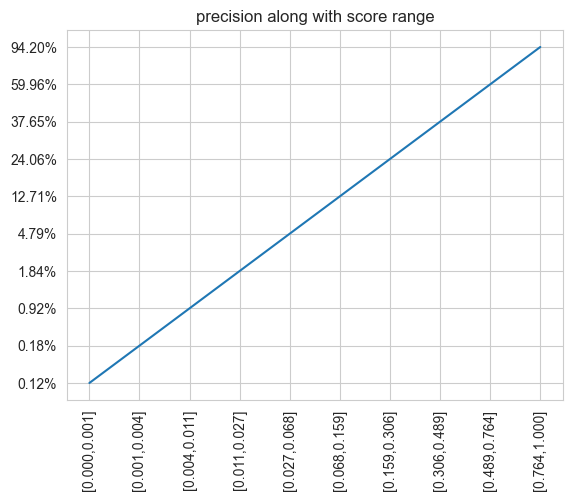

In [134]:
score_range_precision=topn_score_result_df[["score_range","hit_rate"]].sort_values(by="score_range", ascending=True)
plt.plot(score_range_precision["score_range"],score_range_precision["hit_rate"])
plt.xticks(rotation=90)
plt.title("precision along with score range")
plt.show()


In [139]:
#############################################
# 评估模型-3-KS
# KS (Kolmogorov-Smirnov) 曲线是评估二分类模型区分能力的重要工具。
# 选取合适阈值
#############################################
"""
1. KS值含义：
- KS值表示正负样本累积分布函数的最大差值
- 取值范围在[0,1]之间，越大表示模型区分能力越强
- 一般认为：
         KS > 0.4：模型区分能力较强
         0.3 <= KS <= 0.4：模型区分能力一般
         KS < 0.3：模型区分能力较弱
2. KS曲线组成：
- TPR曲线：真阳性率（正样本累积分布）
- FPR曲线：假阳性率（负样本累积分布）
- KS曲线：TPR与FPR的差值
3.实际应用：
- 模型评估：评估模型区分好坏样本的能力
- 阈值选择：KS值最大点对应的阈值常用作分类阈值
- 风险控制：在信用评分等场景下广泛使用
4.注意事项：
- KS值对样本不平衡不敏感
- 需要结合业务场景选择合适的阈值
- 建议与其他指标（如AUC、PR曲线）一起使用
"""

def plot_ks_curve(y_true, y_pred_proba, n_bins=10):
    """
    计算KS值并绘制KS曲线
    
    参数:
    y_true: 真实标签 (0/1)
    y_pred_proba: 预测概率
    n_bins: 分箱数量
    
    返回:
    ks_value: KS统计量
    ks_stats: 包含详细统计信息的DataFrame
    """
    
    # 计算FPR、TPR和阈值
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # 计算KS值和对应的阈值
    ks_values = tpr - fpr
    ks_value = np.max(ks_values)
    ks_threshold = thresholds[np.argmax(ks_values)]
    
    # 绘制KS曲线
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr[:-1], label='TPR (真阳性率)', color='blue')
    plt.plot(thresholds, fpr[:-1], label='FPR (假阳性率)', color='red')
    plt.plot(thresholds, ks_values[:-1], label='KS曲线', color='green')
    
    # 标注最大KS值点
    plt.vlines(ks_threshold, fpr[np.argmax(ks_values)], 
              tpr[np.argmax(ks_values)], colors='gray', linestyles='--')
    plt.plot([ks_threshold], [fpr[np.argmax(ks_values)]], 'ro')
    plt.plot([ks_threshold], [tpr[np.argmax(ks_values)]], 'bo')
    
    # 添加标签和标题
    plt.title(f'KS曲线 (KS值 = {ks_value:.3f})')
    plt.xlabel('阈值')
    plt.ylabel('比率')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 计算详细的分箱统计信息
    df = pd.DataFrame({
        'y_true': y_true,
        'score': y_pred_proba
    })
    
    # 按分数排序并分箱
    df = df.sort_values('score', ascending=False)
    df['bin'] = pd.qcut(df['score'], n_bins, labels=range(n_bins))
    
    # 计算每个分箱的统计量
    stats = []
    total_positive = df['y_true'].sum()
    total_negative = len(df) - total_positive
    
    cum_positive = 0
    cum_negative = 0
    
    for bin_idx in range(n_bins):
        bin_data = df[df['bin'] == bin_idx]
        bin_positive = bin_data['y_true'].sum()
        bin_negative = len(bin_data) - bin_positive
        
        cum_positive += bin_positive
        cum_negative += bin_negative
        
        tpr = cum_positive / total_positive if total_positive > 0 else 0
        fpr = cum_negative / total_negative if total_negative > 0 else 0
        ks = tpr - fpr
        
        stats.append({
            'bin': bin_idx + 1,
            'score_min': bin_data['score'].min(),
            'score_max': bin_data['score'].max(),
            'count': len(bin_data),
            'positive': bin_positive,
            'negative': bin_negative,
            'positive_rate': bin_positive / len(bin_data),
            'cum_positive_rate': tpr,
            'cum_negative_rate': fpr,
            'ks': ks
        })
    
    ks_stats = pd.DataFrame(stats)
    
    # 格式化百分比列
    percent_columns = ['positive_rate', 'cum_positive_rate', 'cum_negative_rate', 'ks']
    for col in percent_columns:
        ks_stats[col] = ks_stats[col].map('{:.2%}'.format)
        
    return ks_value, ks_stats



ValueError: x and y must have same first dimension, but have shapes (4264,) and (4263,)

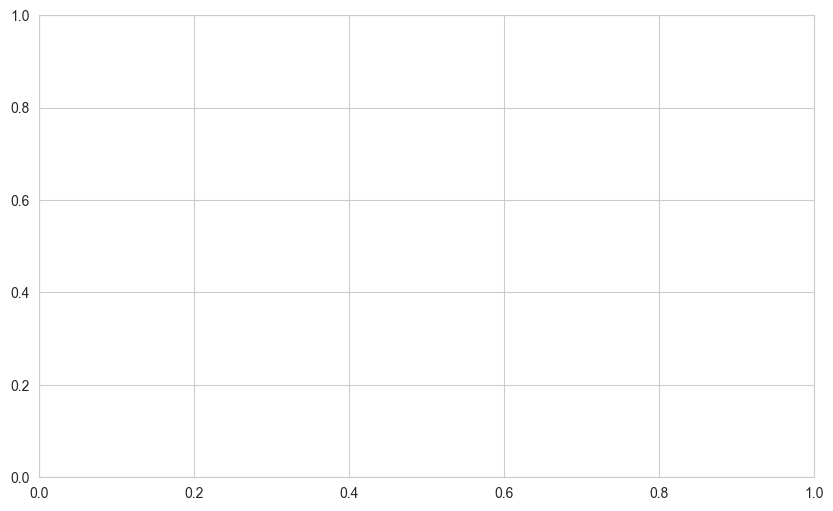

In [140]:
ks_value, ks_stats=plot_ks_curve(test_label,y_pred_prob)


In [137]:
len(test_label)

16280

In [138]:
len(y_pred_prob)

16280